# MovieLense

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

2024-11-17 07:48:31.591722: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 07:48:31.600939: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 07:48:31.682678: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 07:48:31.782514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731826111.882950    9792 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731826111.91

## Get data and preprocess

In [2]:
def get_data(ds_name = 'movielens/100k-ratings'):
  def genre_id_to_text(genre_ids):
    return [genres[id] for id in genre_ids]

  ds=  tfds.load(ds_name, split='all')
  df = tfds.as_dataframe(ds)

  for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].apply(
            lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
        )

  genres = ['Action' ,'Adventure' ,'Animation',
        'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy',
        'Film-Noir' ,'Horror' ,'IMAX' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi',
        'Thriller' ,'War' ,'Western', 'unknown']
  df['genres_id'] = df['movie_genres']
  df['movie_genres'] = df['movie_genres'].apply(genre_id_to_text)

  return df


In [3]:
movie_ratings_df = get_data()

2024-11-17 07:48:44.346842: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-11-17 07:48:44.721981: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2024-11-17 07:49:32.202739: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## EDA

In [4]:
movie_ratings_df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,genres_id
0,45.0,[Drama],357,One Flew Over the Cuckoo's Nest (1975),46.0,879024327,True,138,4,doctor,4.0,53211,[7]
1,25.0,"[Comedy, Romance]",709,Strictly Ballroom (1992),32.0,875654590,True,92,5,entertainment,2.0,80525,"[4, 14]"
2,18.0,[Comedy],412,"Very Brady Sequel, A (1996)",24.0,882075110,True,301,17,student,4.0,55439,[4]
3,50.0,"[Crime, Drama]",56,Pulp Fiction (1994),50.0,883326919,True,60,4,healthcare,4.0,06472,"[5, 7]"
4,50.0,"[Horror, Thriller]",895,Scream 2 (1997),55.0,891409199,True,197,18,technician,3.0,75094,"[10, 16]"


In [5]:
movie_ratings_df.describe()

,bucketized_user_age,raw_user_age,timestamp,user_occupation_label,user_rating
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,29.235460,32.969849,8.835289e+08,11.404320,3.529860
std,12.005926,11.562623,5.343856e+06,6.549283,1.125674
min,1.000000,7.000000,8.747247e+08,0.000000,1.000000
25%,18.000000,24.000000,8.794487e+08,6.000000,3.000000
50%,25.000000,30.000000,8.828269e+08,12.000000,4.000000
75%,35.000000,40.000000,8.882600e+08,17.000000,4.000000
max,56.000000,73.000000,8.932866e+08,21.000000,5.000000


In [6]:
movie_ratings_df.dtypes

bucketized_user_age      float32
movie_genres              object
movie_id                  object
movie_title               object
raw_user_age             float32
timestamp                  int64
user_gender                 bool
user_id                   object
user_occupation_label      int64
user_occupation_text      object
user_rating              float32
user_zip_code             object
genres_id                 object
dtype: object

### Genra statistics

In [7]:
genre_counts = movie_ratings_df.explode('movie_genres')['movie_genres'].value_counts()

In [8]:
average_ratings = movie_ratings_df.explode('movie_genres').groupby('movie_genres')['user_rating'].mean()

In [9]:
unique_movies_count = movie_ratings_df.explode('movie_genres').groupby('movie_genres')['movie_id'].nunique()

In [10]:
genre_statistics = pd.DataFrame({
    'Number of Movies': genre_counts,
    'Average Rating': average_ratings,
    'Unique Movies Count': unique_movies_count
}).fillna(0)

In [11]:
genre_statistics.sort_values(by='Number of Movies', ascending=False).head(5)

,Number of Movies,Average Rating,Unique Movies Count
movie_genres,,,
Drama,39895,3.687379,725
Comedy,29832,3.394073,505
Action,25589,3.480245,251
Thriller,21872,3.509007,251
Romance,19461,3.621705,247


In [12]:
genre_statistics.sort_values(by='Average Rating', ascending=False).head(5)

,Number of Movies,Average Rating,Unique Movies Count
movie_genres,,,
Film-Noir,1733,3.921523,24
Western,9398,3.815812,71
Drama,39895,3.687379,725
Documentary,758,3.672823,50
Mystery,5245,3.638132,61


In [13]:
genre_statistics.sort_values(by='Unique Movies Count', ascending=False).head(5)

,Number of Movies,Average Rating,Unique Movies Count
movie_genres,,,
Drama,39895,3.687379,725
Comedy,29832,3.394073,505
Action,25589,3.480245,251
Thriller,21872,3.509007,251
Romance,19461,3.621705,247


In [14]:
exploded_genres = movie_ratings_df.explode('movie_genres')

In [15]:
genre_counts = exploded_genres['movie_genres'].value_counts()

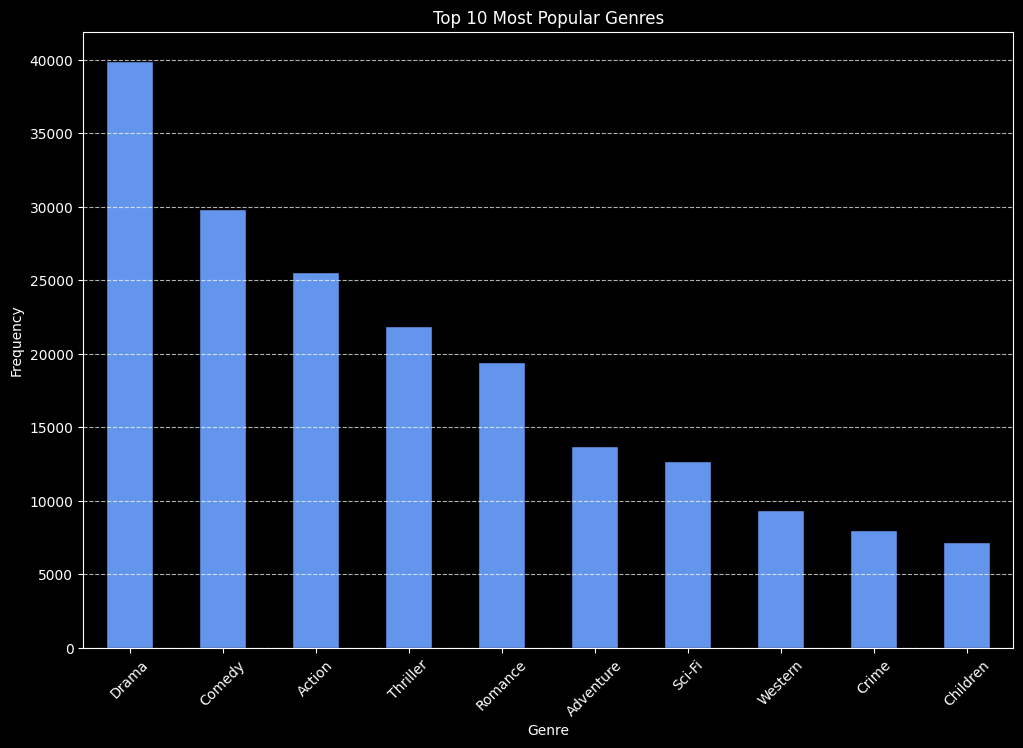

In [16]:
plt.figure(figsize=(12, 8))
genre_counts.head(10).plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title("Top 10 Most Popular Genres")
plt.xlabel("Genre")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

#### Word cloud

In [17]:
all_genres = movie_ratings_df.explode('movie_genres')['movie_genres'].tolist()
text = ' '.join(all_genres)

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='PuBu').generate(text)

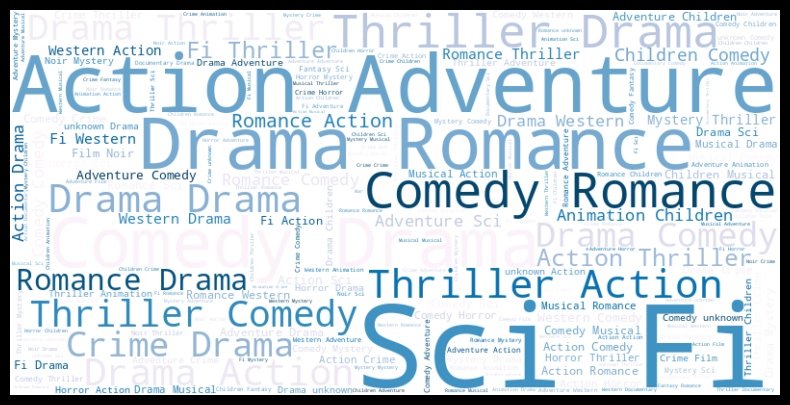

In [19]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see that the most popular genra combinations include: drama and romance, action and adventure, comedy and romace, comedy and drama.

### User rating analysis

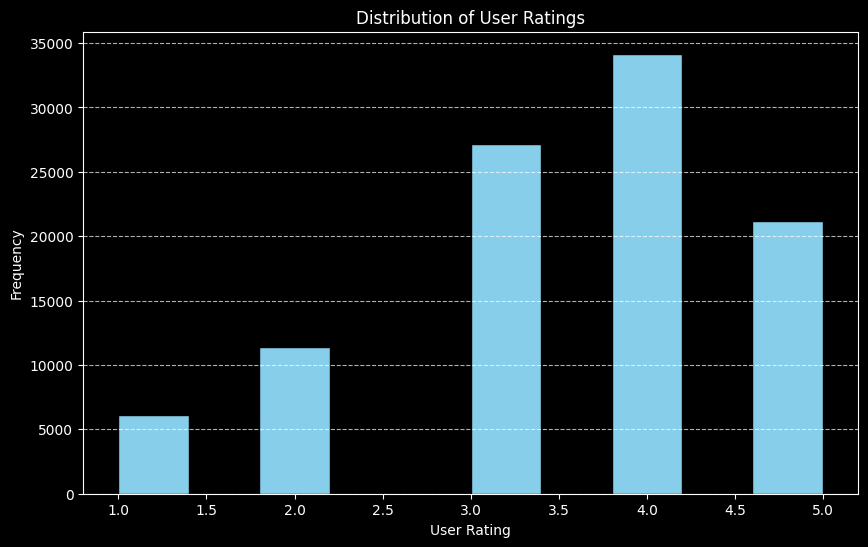

In [20]:
plt.figure(figsize=(10, 6))
movie_ratings_df['user_rating'].plot(kind='hist', bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of User Ratings")
plt.xlabel("User Rating")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

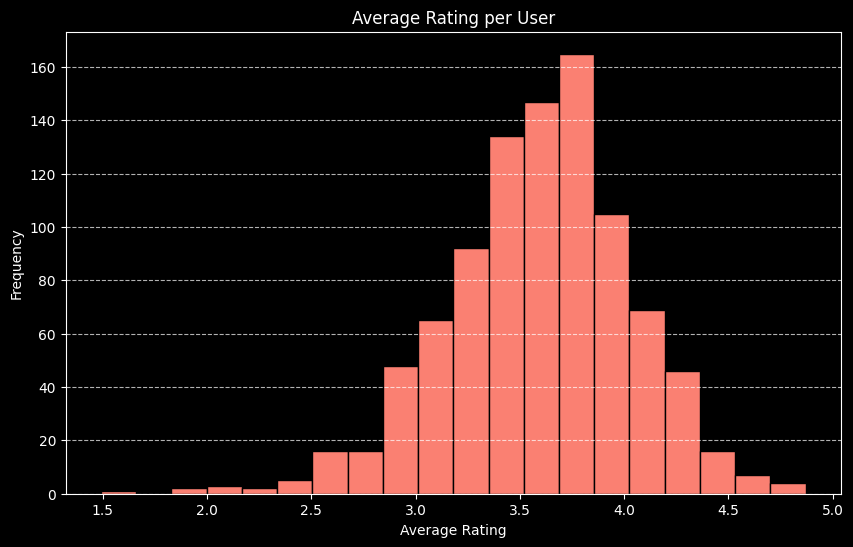

In [21]:
average_rating_per_user = movie_ratings_df.groupby('user_id')['user_rating'].mean()
plt.figure(figsize=(10, 6))
average_rating_per_user.plot(kind='hist', bins=20, color='salmon', edgecolor='black')
plt.title("Average Rating per User")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Ratings by age

In [22]:
age_group_rating = movie_ratings_df.groupby(['bucketized_user_age'])['user_rating'].mean()
age_group_rating

bucketized_user_age
1.0     3.423525
18.0    3.473525
25.0    3.488376
35.0    3.588485
45.0    3.629173
50.0    3.629323
56.0    3.651703
Name: user_rating, dtype: float32

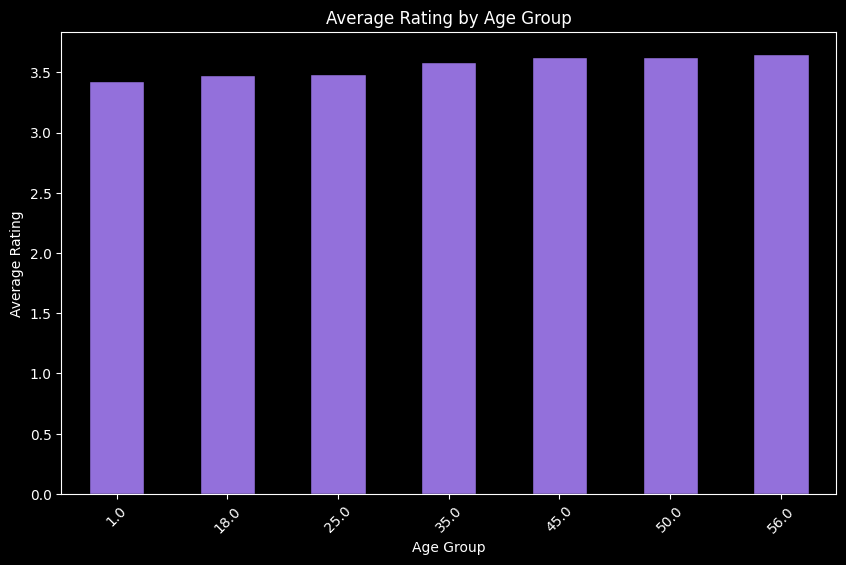

In [23]:
plt.figure(figsize=(10, 6))
age_group_rating.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.title("Average Rating by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

#### Ratings by gender

In [24]:
gender_rating  = movie_ratings_df.groupby(['user_gender'])['user_rating'].mean()
gender_rating

user_gender
False    3.531507
True     3.529289
Name: user_rating, dtype: float32

### Movie popularity

In [25]:
most_rated_movies = movie_ratings_df['movie_title'].value_counts().head(10)
most_rated_movies

movie_title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: count, dtype: int64

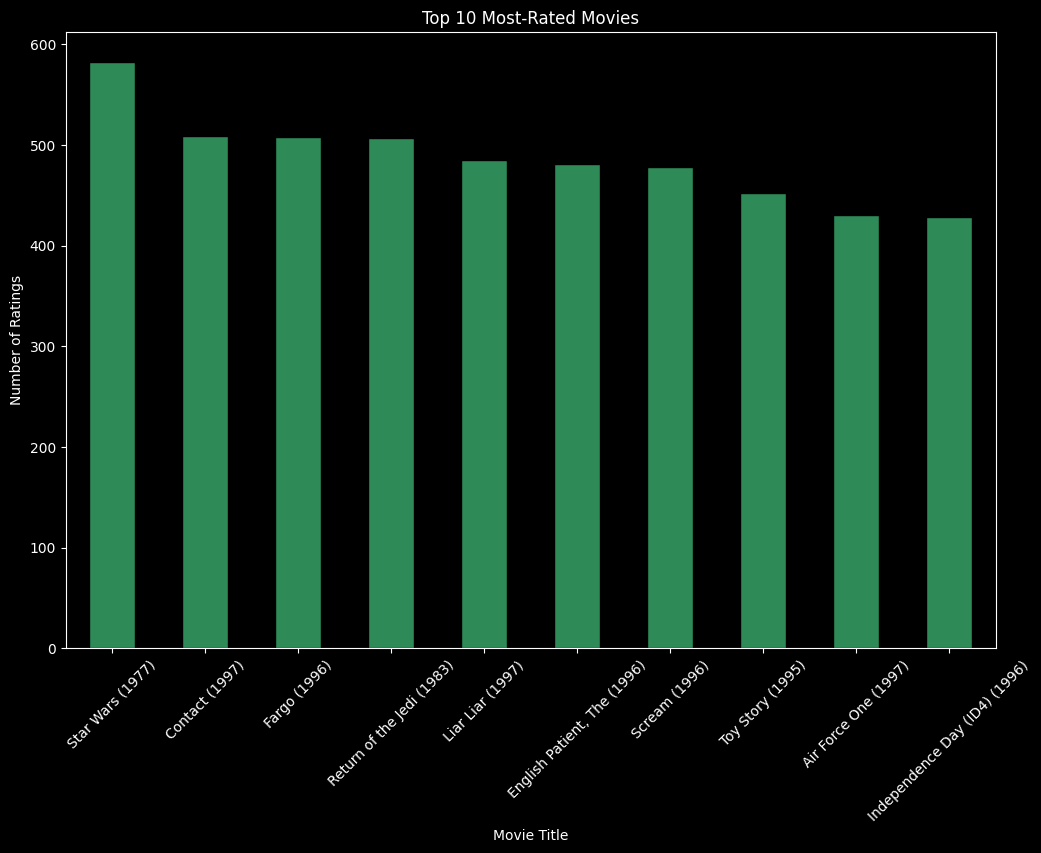

In [26]:
plt.figure(figsize=(12, 8))
most_rated_movies.plot(kind='bar', color='seagreen', edgecolor='black')
plt.title("Top 10 Most-Rated Movies")
plt.xlabel("Movie Title")
plt.ylabel("Number of Ratings")
plt.xticks(rotation=45)
plt.show()

In [27]:
movie_avg_rating = movie_ratings_df.groupby('movie_title')['user_rating'].mean()
movie_rating_counts = movie_ratings_df['movie_title'].value_counts()
highly_rated_movies = movie_avg_rating[movie_rating_counts >= 50].sort_values(ascending=False).head(10)

In [28]:
highly_rated_movies

movie_title
Close Shave, A (1995)                                     4.491071
Schindler's List (1993)                                   4.466443
Wrong Trousers, The (1993)                                4.466102
Casablanca (1942)                                         4.456790
Wallace & Gromit: The Best of Aardman Animation (1996)    4.447761
Shawshank Redemption, The (1994)                          4.445230
Rear Window (1954)                                        4.387560
Usual Suspects, The (1995)                                4.385768
Star Wars (1977)                                          4.358490
12 Angry Men (1957)                                       4.344000
Name: user_rating, dtype: float32

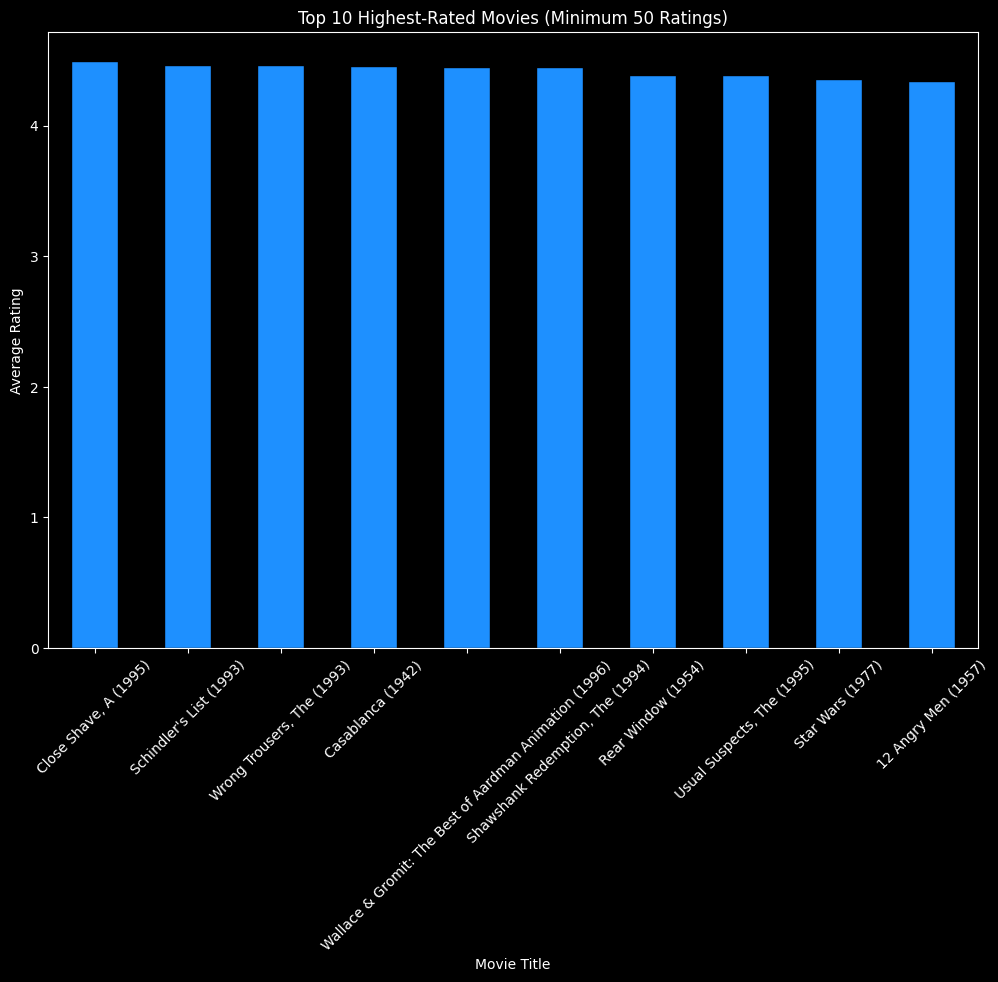

In [29]:
plt.figure(figsize=(12, 8))
highly_rated_movies.plot(kind='bar', color='dodgerblue', edgecolor='black')
plt.title("Top 10 Highest-Rated Movies (Minimum 50 Ratings)")
plt.xlabel("Movie Title")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()